<a href="https://colab.research.google.com/github/arifchuuw/LIGO_GW_Tutorials/blob/main/Lab8_CNN_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising

##1. importing resources

In [ ]:
%matplotlib inline
!pip install h5py

import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import IPython
import h5py
import numpy.random as random
from sklearn.preprocessing import StandardScaler
import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# connect to drive for data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# importing data and checking structure, only use the test data set
signal = h5py.File('/content/drive/MyDrive/Colab Notebooks/427_final_project/Copy of CCSN_Pan_SNR_Free.h5','r')
signal_test = h5py.File('/content/drive/MyDrive/Colab Notebooks/427_final_project/Copy of CCSN_Pan_SNR_Free_Test_Validation.h5','r')

print(signal.keys())
print(signal['Model_FR'].keys())
print(signal['Noise'].keys())

# collapsing star not rotating
signal_NR_test = signal_test['Model_NR']['Hp']

# rotating slowly
signal_SR_test = signal_test['Model_SR']['Hp']

# rotating fast
signal_FR_test = signal_test['Model_FR']['Hp']

# noise
noise_test = signal_test['Noise']['Strain']

# not sure what this data is
dis_test = signal_test['Dis']

print('test signal structure:'+ str(signal_NR_test.shape))
print('test signal structure:'+ str(noise_test.shape))
# record data length per sample
feature_len = noise_test.shape[1]

<KeysViewHDF5 ['Dis', 'Model_FR', 'Model_NR', 'Model_SR', 'Noise']>
<KeysViewHDF5 ['Hp']>
<KeysViewHDF5 ['Strain']>
test signal structure:(6250, 8192)
test signal structure:(18750, 8192)


In [ ]:
# scale the given data

scaler = StandardScaler()
# strain is containing both signal and noise
Strain_NR = scaler.fit_transform(signal_NR_test)
Strain_SR = scaler.fit_transform(signal_SR_test)
Strain_FR = scaler.fit_transform(signal_FR_test)
noise = scaler.fit_transform(noise_test)

## 2. visualizing the data

### 2 seconds segment,</br> 8192 data points/sample,</br> time interval = 0.00024s, </br>

In [ ]:
# plotting function
# red represents stain
# blue represents background
def signal_plot(signal_type, index, label):
  z = index

  # giving y value
  y = signal_type[z]
  y_n = noise_test[z]

  t = np.array(np.linspace(0,2,num=8192))
  plt.plot(t, y, 'r')
  plt.plot(t, y_n, 'b')
  plt.ylabel('time (s)')
  plt.xlabel('wave strength')
  plt.title(label)
  plt.show()

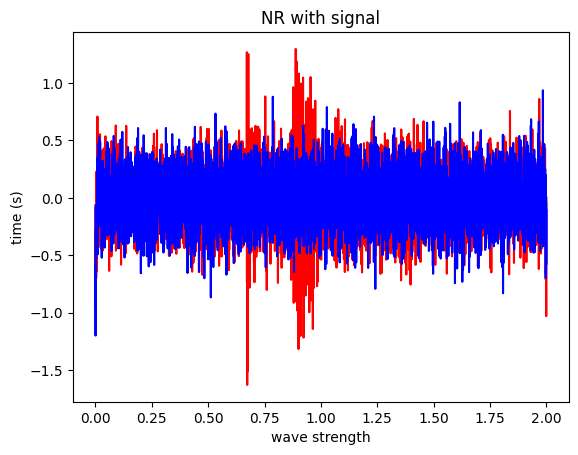

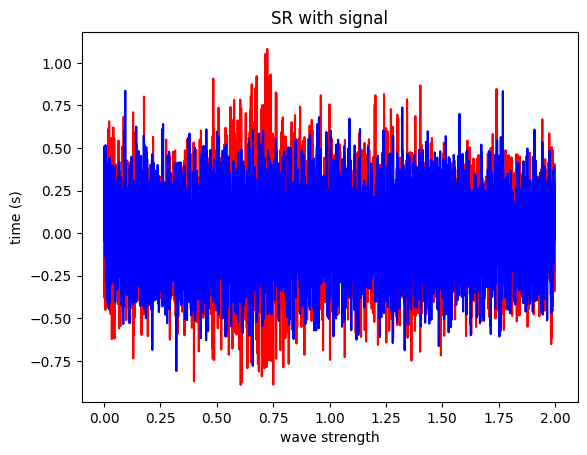

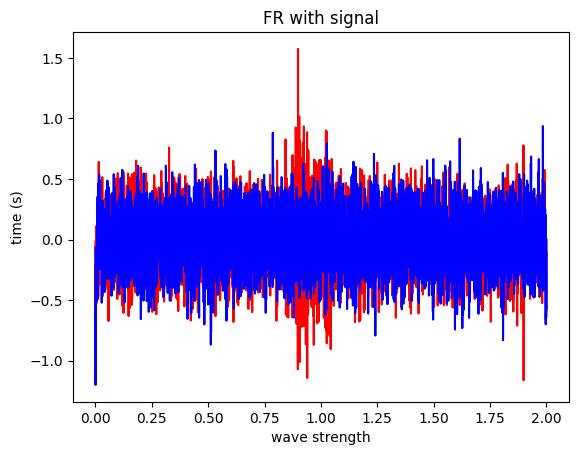

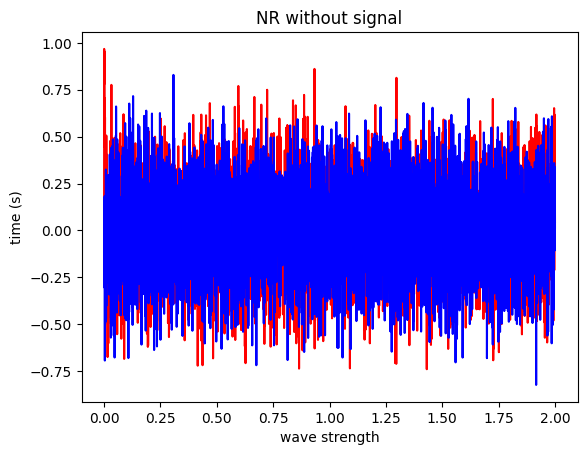

In [ ]:
#plotting with signals and without signals
signal_plot(signal_NR_test, 16, label = 'NR with signal')
signal_plot(signal_SR_test, 2, label = 'SR with signal')
signal_plot(signal_FR_test, 16, label = 'FR with signal')
signal_plot(signal_NR_test, 5, label = 'NR without signal')

## 3. preparing data

In [ ]:
# making features targets after shuffling
# n:= noise
# s:= strain

def shuffle(n, s):
  # containers
  feature=[]
  target=[]

  # random the index
  index = random.permutation(len(n) + len(s))

  for i in index:
    if i < len(s) :
      # take sample from signal parkets
      feature.append(s[i])
      target.append(1) # strain w/ signal = 1
    else:
      # take sample from noise parkets
      feature.append(n[i-len(s)])
      target.append(0)

  return np.array(feature), np.array(target)

In [ ]:
# sample size unit
length = 125

# test samples
# first len samples/type from strain  125*3
# with 3*len samples from noise   125*3
# in total test size be 6*len samples  750
test_NR = Strain_NR[:length]
test_SR = Strain_SR[:length]
test_FR = Strain_FR[:length]
test_noise = noise[:length*3]  # go to 0
test_strain = np.concatenate((test_NR, test_SR, test_FR)) # go to 1
# combine and shuffle
test_features, test_targets = shuffle(test_noise, test_strain)


# valid samples
# next len samples/type from strain  125*3
# with 3*len samples from noise   125*3
# in total valid size be 6*len samples  750
valid_NR = Strain_NR[length:length*2]
valid_SR = Strain_SR[length:length*2]
valid_FR = Strain_FR[length:length*2]
valid_noise = noise[length*3:length*3*2]
valid_strain = np.concatenate((valid_NR, valid_SR, valid_FR))
# combine and shuffle
validation_features, validation_targets = shuffle(valid_noise, valid_strain)


# train samples
# next 8*len samples/type from strain 125*8*3
# with 24*len samples from noise  125*8*3
# in total valid size be 48*len samples 6000
train_NR = Strain_NR[length*2:length*10]
train_SR = Strain_SR[length*2:length*10]
train_FR = Strain_FR[length*2:length*10]
train_noise = noise[length*3*2:length*3*10]
train_strain = np.concatenate((train_NR, train_SR, train_FR))
# combine and shuffle
train_features, train_targets = shuffle(train_noise, train_strain)

In [ ]:
# rescale them into channel form for CNN
# channel = 1

# getting length
train_len = len(train_features)
test_len = len(test_features)
valid_len = len(validation_features)
print('the length of train/test/valid is', train_len, '/', test_len, 
      '/', valid_len)

# rescale, only needed for features
train_features = np.reshape(train_features, (train_len, 1, feature_len))
test_features = np.reshape(test_features, (test_len, 1, feature_len))
validation_features = np.reshape(validation_features, (valid_len, 1, feature_len))

# check shape
print('train shape: ', train_features.shape)
print('test shape: ', test_features.shape)
print('valid shape: ', validation_features.shape)

the length of train/test/valid is 6000 / 750 / 750
train shape:  (6000, 1, 8192)
test shape:  (750, 1, 8192)
valid shape:  (750, 1, 8192)


## 4. Define Model

In [ ]:
class CNNModel(torch.nn.Module):

  def __init__(self):    

        super(CNNModel, self).__init__()

        # size_calc := (input_size - ker)/str + 1 + 2*padd
        self.cnn1 = torch.nn.Conv1d(in_channels=1, out_channels=10, 
                              kernel_size=5, stride=1, padding=2)
        # 8192 -size_calc-> 8192 -pool-> 4096
        
        self.cnn2 = torch.nn.Conv1d(in_channels=10, out_channels=20, 
                              kernel_size=5, stride=1, padding=2)
        # 4096 -size_calc-> 4096 -pool-> 2048

        self.cnn3 = torch.nn.Conv1d(in_channels=20, out_channels=10, 
                              kernel_size=5, stride=1, padding=2)
        # 2048 -size_calc-> 2048 -pool-> 1024  
        
        self.cnn4 = torch.nn.Conv1d(in_channels=10, out_channels=5, 
                              kernel_size=5, stride=1, padding=2)   
        # 1024 -size_calc> 1024 -pool-> 512 
        
        self.fc1 = torch.nn.Linear(512*5, 512)  

        self.fc2 = torch.nn.Linear(512, 2) # for binary classification

        # set max pool with kernel size 2 for all the layers  
        self.maxpool = torch.nn.MaxPool1d(kernel_size=2)

        # set drop out 1d to prevent overfitting
        self.conv1_drop = torch.nn.Dropout1d()

    
  def forward(self, x):
        
        x = torch.nn.functional.relu(self.maxpool(self.cnn1(x))) # layer 1   
        
        x = torch.nn.functional.relu(self.maxpool(self.cnn2(x))) # layer 2

        x = torch.nn.functional.relu(self.maxpool(self.cnn3(x))) # layer 3

        x = torch.nn.functional.relu(self.maxpool(self.cnn4(x))) # layer 4
    
        # flatten the output
        x = torch.flatten(x, 1)
    
        # fully connected layers
        x = torch.nn.functional.relu(self.fc1(x))

        output = torch.nn.functional.softmax(self.fc2(x), 1)
        
        return output

## 5. Define hyper parameter and tracker

In [ ]:
#@title Define hyper parameter
learning_rate = 0.01 #@param {type:"number"}
epochs = 25 #@param {type:"slider", min:0, max:100, step:1}
batchsize = 100 #@param {type:"slider", min:0, max:250, step:5}


### Define model

In [ ]:
# define model
model = CNNModel()

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate,
                             weight_decay=1e-5)

# tracked data
train_loss_list = []
valid_accuracy_list = np.zeros((epochs,))
check_pred = []

model

CNNModel(
  (cnn1): Conv1d(1, 10, kernel_size=(5,), stride=(1,), padding=(2,))
  (cnn2): Conv1d(10, 20, kernel_size=(5,), stride=(1,), padding=(2,))
  (cnn3): Conv1d(20, 10, kernel_size=(5,), stride=(1,), padding=(2,))
  (cnn4): Conv1d(10, 5, kernel_size=(5,), stride=(1,), padding=(2,))
  (fc1): Linear(in_features=2560, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1_drop): Dropout1d(p=0.5, inplace=False)
)

## 6. Train Model

In [ ]:
# converting to torch
# feature -> float, target -> int64
train_inputs = torch.from_numpy(train_features).float()
train_targets = torch.from_numpy(train_targets).long()

validation_inputs = torch.from_numpy(validation_features).float()
validation_targets = torch.from_numpy(validation_targets).long()

testing_inputs = torch.from_numpy(test_features).float()
testing_targets = torch.from_numpy(test_targets).long()

# splitting the batches
train_batches_features = torch.split(train_inputs, batchsize)
train_batches_targets = torch.split(train_targets, batchsize)

batch_num = len(train_batches_features)

# check size
print(train_batches_features[0].shape)
print(train_batches_targets[0].shape)

torch.Size([100, 1, 8192])
torch.Size([100])


In [ ]:
# train
for epoch in tqdm(range(epochs)):

    # train each batch
    for i in tqdm(range(batch_num)):

      optimizer.zero_grad()

      train_batch_feature = train_batches_features[i]
      train_batch_target = train_batches_targets[i]

      train_batch_output = model(train_batch_feature)

      loss = loss_func(train_batch_output, train_batch_target)

      train_loss_list.append(loss.item())

      loss.backward()

      optimizer.step()

    
    # validation
    with torch.no_grad():

        validation_outputs = model(validation_inputs)

        correct = (torch.argmax(validation_outputs, dim=1) == 
                   validation_targets).type(torch.FloatTensor)
        
        print("Epoch: "+ str(epoch), 
              "Validation Accuracy: " + 
              str(np.round(correct.mean().numpy() * 100, 2)) + '%', flush=True)

        valid_accuracy_list[epoch] = correct.mean()

        # for test, record prediction
        check_pred.append(torch.argmax(validation_outputs
                                       , dim=1).type(torch.FloatTensor).numpy())


100%|██████████| 60/60 [00:44<00:00,  1.34it/s]


Epoch: 0 Validation Accuracy: 83.2%


100%|██████████| 60/60 [00:43<00:00,  1.37it/s]


Epoch: 1 Validation Accuracy: 84.27%


100%|██████████| 60/60 [00:43<00:00,  1.38it/s]


Epoch: 2 Validation Accuracy: 85.47%


100%|██████████| 60/60 [00:45<00:00,  1.31it/s]


Epoch: 3 Validation Accuracy: 88.4%


100%|██████████| 60/60 [00:50<00:00,  1.19it/s]


Epoch: 4 Validation Accuracy: 87.6%


100%|██████████| 60/60 [00:45<00:00,  1.32it/s]


Epoch: 5 Validation Accuracy: 89.33%


100%|██████████| 60/60 [00:45<00:00,  1.33it/s]


Epoch: 6 Validation Accuracy: 87.6%


100%|██████████| 60/60 [00:42<00:00,  1.40it/s]


Epoch: 7 Validation Accuracy: 87.47%


100%|██████████| 60/60 [00:44<00:00,  1.34it/s]


Epoch: 8 Validation Accuracy: 88.27%


100%|██████████| 60/60 [00:47<00:00,  1.25it/s]


Epoch: 9 Validation Accuracy: 83.87%


100%|██████████| 60/60 [00:46<00:00,  1.30it/s]


Epoch: 10 Validation Accuracy: 85.47%


100%|██████████| 60/60 [00:44<00:00,  1.35it/s]


Epoch: 11 Validation Accuracy: 85.73%


100%|██████████| 60/60 [00:45<00:00,  1.32it/s]


Epoch: 12 Validation Accuracy: 86.8%


100%|██████████| 60/60 [00:44<00:00,  1.34it/s]


Epoch: 13 Validation Accuracy: 86.4%


100%|██████████| 60/60 [00:44<00:00,  1.35it/s]


Epoch: 14 Validation Accuracy: 87.87%


100%|██████████| 60/60 [00:46<00:00,  1.30it/s]


Epoch: 15 Validation Accuracy: 87.33%


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


Epoch: 16 Validation Accuracy: 86.27%


100%|██████████| 60/60 [00:45<00:00,  1.31it/s]


Epoch: 17 Validation Accuracy: 83.87%


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


Epoch: 18 Validation Accuracy: 85.73%


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


Epoch: 19 Validation Accuracy: 85.73%


100%|██████████| 60/60 [00:48<00:00,  1.25it/s]


Epoch: 20 Validation Accuracy: 85.73%


100%|██████████| 60/60 [00:49<00:00,  1.22it/s]


Epoch: 21 Validation Accuracy: 82.67%


100%|██████████| 60/60 [00:48<00:00,  1.25it/s]


Epoch: 22 Validation Accuracy: 87.33%


100%|██████████| 60/60 [00:48<00:00,  1.24it/s]


Epoch: 23 Validation Accuracy: 86.67%


100%|██████████| 60/60 [00:56<00:00,  1.06it/s]


Epoch: 24 Validation Accuracy: 86.13%


100%|██████████| 25/25 [20:17<00:00, 48.70s/it]


## 7. Visualize result

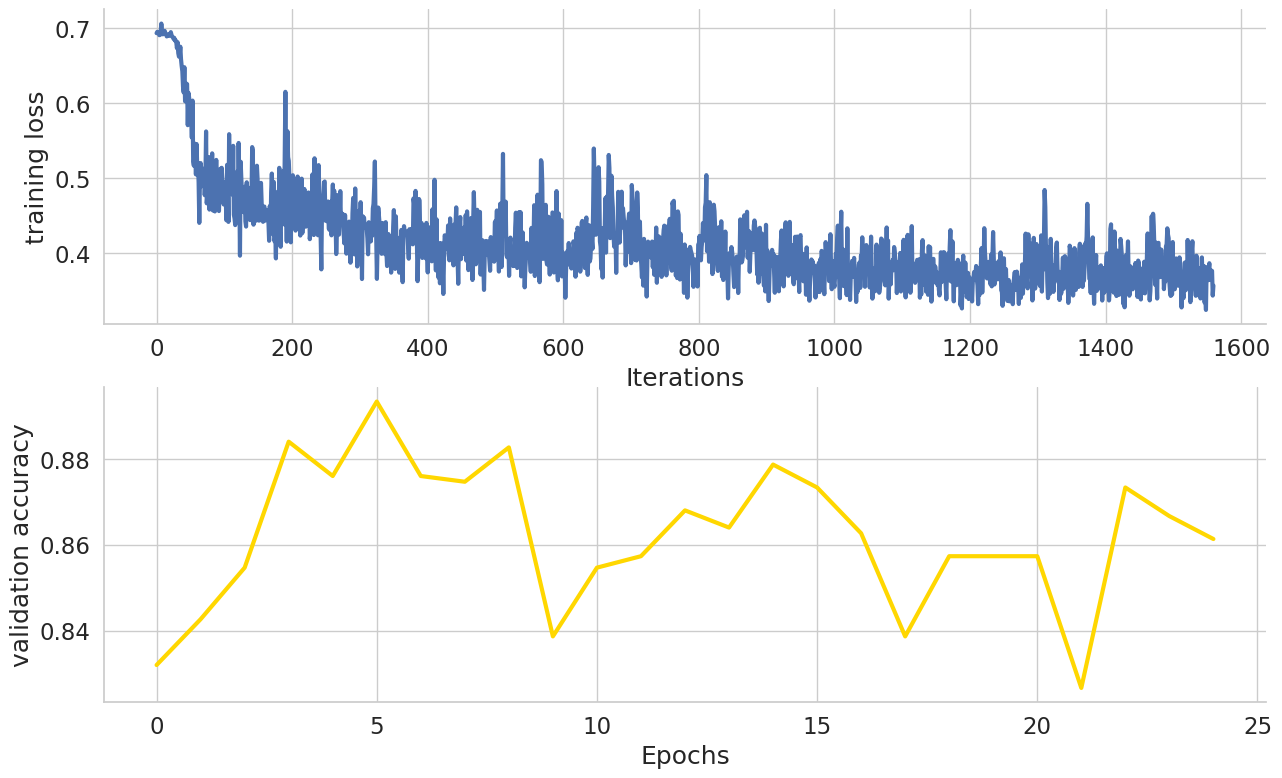

In [ ]:
# for prettier graph, w/ whitegrid
sns.set(style = 'whitegrid', font_scale = 1.5)

# Plot training loss and validation accuracy throughout the training
plt.figure(figsize = (15, 9))

plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("Iterations")
sns.despine()

plt.subplot(2, 1, 2)
plt.plot(valid_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
plt.xlabel("Epochs")
sns.despine()

In [ ]:
# Compute the testing accuracy 

with torch.no_grad():
    
    y_pred_test = model(testing_inputs)
    correct = (torch.argmax(y_pred_test, dim=1) == testing_targets).type(torch.FloatTensor)
    
    print("Testing Accuracy: " + str(correct.mean().numpy()))

Testing Accuracy: 0.85733336
